In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

### **Data Processing**

In [2]:
import os
import shutil
from random import shuffle

# Define source and target directories
# https://github.com/microsoft/DigiFace1M
source_dir = "/Users/revanthmedukonduru/Downloads/subjects_0-1999_72_imgs/" # Original dataset directory - downloaded from : https://github.com/microsoft/DigiFace1M (P1 - Dataset)
train_target_dir = "data/train" # Train dataset directory
test_target_dir = "data/test" # Test dataset directory (Validation dataset is not used in this project)
no_of_classes_considered = 10 # Number of classes to consider (we have 2000 Classes)
min_images_per_class = 70 # Minimum number of images per class (we have 72 images per class generally in each class in this dataset)

# Create train and test directories if they don't exist
os.makedirs(train_target_dir, exist_ok=True)
os.makedirs(test_target_dir, exist_ok=True)

# List all the person folders
persons = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

# only keep folders with more than 70 images
persons = [person for person in persons if len(os.listdir(os.path.join(source_dir, person))) > min_images_per_class]

# only keep randomly selected 10 classes
shuffle(persons)
persons = persons[:no_of_classes_considered]

for person in tqdm(persons):
    # List all images of the person
    images = [f for f in os.listdir(os.path.join(source_dir, person)) if f.endswith(('.png', '.jpg', '.jpeg'))]
    shuffle(images)

    # Calculate split index
    split_idx = int(0.7 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Define person-specific directories in train and test
    train_person_dir = os.path.join(train_target_dir, person)
    test_person_dir = os.path.join(test_target_dir, person)

    os.makedirs(train_person_dir, exist_ok=True)
    os.makedirs(test_person_dir, exist_ok=True)

    # Move and rename images to respective directories
    for idx, img in enumerate(train_images):
        new_img_name = str(idx) + os.path.splitext(img)[-1]  # new name with extension
        shutil.move(os.path.join(source_dir, person, img), os.path.join(train_person_dir, new_img_name))

    for idx, img in enumerate(test_images):
        new_img_name = str(idx) + os.path.splitext(img)[-1]  # new name with extension
        shutil.move(os.path.join(source_dir, person, img), os.path.join(test_person_dir, new_img_name))

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
# Print no of images available in each class
print("No of images available in each class:")
for person in persons:
    print(f"Person Id: {person}: Train: {len(os.listdir(os.path.join(train_target_dir, person)))}, Test: {len(os.listdir(os.path.join(test_target_dir, person)))}")

No of images available in each class:
Person Id: 931: Train: 50, Test: 22
Person Id: 33: Train: 50, Test: 22
Person Id: 1934: Train: 50, Test: 22
Person Id: 1480: Train: 50, Test: 22
Person Id: 747: Train: 50, Test: 22
Person Id: 706: Train: 50, Test: 22
Person Id: 1312: Train: 50, Test: 22
Person Id: 609: Train: 50, Test: 22
Person Id: 180: Train: 50, Test: 22
Person Id: 726: Train: 50, Test: 22


In [4]:
# Define the data transformations using ImageDataGenerator
data_generators = {
    'train': ImageDataGenerator(
        rescale=1./255,  # Rescaling
        rotation_range=20,  # Random rotations for data augmentation
        width_shift_range=0.2,  # Random width shift for data augmentation
        height_shift_range=0.2,  # Random height shift for data augmentation
        horizontal_flip=True  # Random horizontal flips for data augmentation
    ),
    'test': ImageDataGenerator(
        rescale=1./255  # Only rescaling for testing data
    )
}

data_dir = 'data/'

# Create data generators from directory
image_data_gen = {
    'train': data_generators['train'].flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(300, 300),
        batch_size=40,
        shuffle=True,
        class_mode='categorical'  # Changed to 'categorical' for multi-class
    ),
    'test': data_generators['test'].flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(300, 300),
        batch_size=40,
        shuffle=True,
        class_mode='categorical'  # Changed to 'categorical' for multi-class
    )
}

Found 500 images belonging to 10 classes.
Found 220 images belonging to 10 classes.


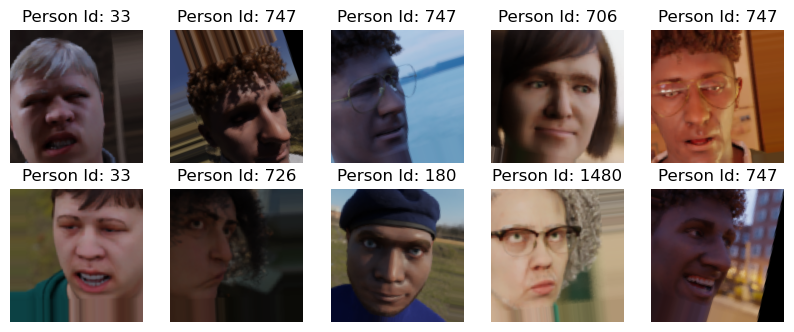

In [5]:
# Plot random 10 images from training data
plt.figure(figsize=(10, 10))
for images, labels in image_data_gen['train']:
    for i in range(10):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Person Id: {persons[labels[i].argmax()]}")
        plt.axis("off")
    break

In [6]:
class_names = list(image_data_gen['train'].class_indices.keys())
print(class_names)
print(len(class_names))

['1312', '1480', '180', '1934', '33', '609', '706', '726', '747', '931']
10


In [8]:
# Checking how many no of batches
train_steps = len(image_data_gen['train'])
test_steps = len(image_data_gen['test'])

print('Number of training batches:', train_steps)
print('Number of Testing batches:', test_steps)

Number of training batches: 13
Number of Testing batches: 6


In [9]:
# get one sample batch from training data
images, labels = image_data_gen['train'].next()
images.shape, labels.shape

((40, 300, 300, 3), (40, 10))

### **Model 0: VGG16**

In [ ]:
model0 = keras.models.Sequential()

model0.add(tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)))

# Other layers
model0.add(keras.layers.Flatten())
model0.add(keras.layers.Dense(256, activation='relu'))
model0.add(keras.layers.Dense(256, activation='relu'))
model0.add(keras.layers.Dense(256, activation='relu'))
model0.add(keras.layers.Dropout(0.3))
model0.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model0.layers[0].trainable = False
model0.summary()

In [21]:
model0.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# VGG16
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model_VGG16.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history = model0.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50


2023-10-08 14:42:13.107326: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 12s 810ms/step - loss: 32.3909 - accuracy: 0.0900
Epoch 2/50
13/13 [==============================] - 11s 792ms/step - loss: 2.5755 - accuracy: 0.1080
Epoch 3/50
13/13 [==============================] - 11s 806ms/step - loss: 2.2924 - accuracy: 0.1040
Epoch 4/50
13/13 [==============================] - 11s 783ms/step - loss: 2.4444 - accuracy: 0.0980
Epoch 5/50
13/13 [==============================] - 11s 810ms/step - loss: 2.2849 - accuracy: 0.1100
Epoch 6/50
13/13 [==============================] - 11s 788ms/step - loss: 2.2980 - accuracy: 0.1140
Epoch 7/50
13/13 [==============================] - 11s 796ms/step - loss: 2.2939 - accuracy: 0.0960
Epoch 8/50
13/13 [==============================] - 11s 830ms/step - loss: 2.3037 - accuracy: 0.0940
Epoch 9/50
13/13 [==============================] - 12s 810ms/step - loss: 2.3034 - accuracy: 0.0900
Epoch 10/50
13/13 [==============================] - 11s 827ms/step - loss: 2.3116 - accuracy: 0.1000

### **Model 1: VGG19 (Dense: F-1024-1024-512-256-0.2D-10C)**

In [32]:
model1 = keras.models.Sequential()

model1.add(tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)))

# Other layers
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(1024, activation='relu'))
model1.add(keras.layers.Dense(1024, activation='relu'))
model1.add(keras.layers.Dense(512, activation='relu'))
model1.add(keras.layers.Dense(256, activation='relu'))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model1.layers[0].trainable = False
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 41472)             0         
                                                                 
 dense_26 (Dense)            (None, 1024)              42468352  
                                                                 
 dense_27 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)              

In [33]:
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# VGG19
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model1_VGG19.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history1 = model1.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 16s 1s/step - loss: 6.3514 - accuracy: 0.1180
Epoch 2/50
13/13 [==============================] - 15s 1s/step - loss: 2.6977 - accuracy: 0.1020
Epoch 3/50
13/13 [==============================] - 15s 1s/step - loss: 2.3739 - accuracy: 0.1000
Epoch 4/50
13/13 [==============================] - 15s 1s/step - loss: 2.3482 - accuracy: 0.0940
Epoch 5/50
13/13 [==============================] - 15s 1s/step - loss: 2.2958 - accuracy: 0.1240
Epoch 6/50
13/13 [==============================] - 15s 1s/step - loss: 2.2695 - accuracy: 0.1480
Epoch 7/50
13/13 [==============================] - 15s 1s/step - loss: 2.2229 - accuracy: 0.1580
Epoch 8/50
13/13 [==============================] - 15s 1s/step - loss: 2.1596 - accuracy: 0.2160
Epoch 9/50
13/13 [==============================] - 15s 1s/step - loss: 2.0981 - accuracy: 0.1960
Epoch 10/50
13/13 [==============================] - 15s 1s/step - loss: 2.0390 - accuracy: 0.2680
Epoch 11/50
13/13 [

In [36]:
# Print train accuracy
m1_train_loss, m1_train_acc = model1.evaluate(image_data_gen['train'])
print("Model 1: Train Loss:", m1_train_loss, "Train Accuracy:", m1_train_acc)

13/13 [==============================] - 14s 1s/step - loss: 0.6921 - accuracy: 0.7540
Model 1: Train Loss: 0.69209885597229 Train Accuracy: 0.7540000081062317


In [37]:
# Evaluate on test data
m1_test_loss, m1_test_acc = model1.evaluate(image_data_gen['test'])
print("Model 1: Test Loss:", m1_test_loss, "Test Accuracy:", m1_test_acc)

6/6 [==============================] - 6s 962ms/step - loss: 0.7175 - accuracy: 0.7727
Model 1: Test Loss: 0.7174795269966125 Test Accuracy: 0.7727272510528564


### **Model 2: VGG16 (Dense: F-1024-1024-512-256-0.2D-10C)**

In [28]:
model2 = keras.models.Sequential()

model2.add(tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)))

# Other layers
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(1024, activation='relu'))
model2.add(keras.layers.Dense(1024, activation='relu'))
model2.add(keras.layers.Dense(512, activation='relu'))
model2.add(keras.layers.Dense(256, activation='relu'))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model2.layers[0].trainable = False
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 41472)             0         
                                                                 
 dense_21 (Dense)            (None, 1024)              42468352  
                                                                 
 dense_22 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)              

In [29]:
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# VGG16
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model2_VGG16.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history2 = model2.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 14s 1s/step - loss: 4.7299 - accuracy: 0.0960
Epoch 2/50
13/13 [==============================] - 13s 967ms/step - loss: 2.6331 - accuracy: 0.1100
Epoch 3/50
13/13 [==============================] - 13s 981ms/step - loss: 2.3278 - accuracy: 0.1240
Epoch 4/50
13/13 [==============================] - 13s 975ms/step - loss: 2.2531 - accuracy: 0.1500
Epoch 5/50
13/13 [==============================] - 13s 964ms/step - loss: 2.0962 - accuracy: 0.2820
Epoch 6/50
13/13 [==============================] - 13s 963ms/step - loss: 1.9061 - accuracy: 0.3280
Epoch 7/50
13/13 [==============================] - 13s 959ms/step - loss: 1.8269 - accuracy: 0.3620
Epoch 8/50
13/13 [==============================] - 13s 947ms/step - loss: 1.6939 - accuracy: 0.4420
Epoch 9/50
13/13 [==============================] - 13s 946ms/step - loss: 1.4107 - accuracy: 0.5000
Epoch 10/50
13/13 [==============================] - 12s 915ms/step - loss: 1.4237 - accuracy:

In [38]:
# Print train accuracy
m2_train_loss, m2_train_acc = model2.evaluate(image_data_gen['train'])
print("Model 2: Train Loss:", m2_train_loss, "Train Accuracy:", m2_train_acc)

13/13 [==============================] - 12s 861ms/step - loss: 0.4459 - accuracy: 0.8420
Model 2: Train Loss: 0.4459395110607147 Train Accuracy: 0.8420000076293945


In [31]:
# Evaluate on test data
m2_test_loss, m2_test_acc = model2.evaluate(image_data_gen['test'])
print("Model2: Test Loss: ", m2_test_loss, "Test Accuracy: ", m2_test_acc)

6/6 [==============================] - 6s 831ms/step - loss: 0.5000 - accuracy: 0.8591
Model2: Test Loss:  0.5000295639038086 Test Accuracy:  0.8590909242630005


### **Model 3: VGG16 (Dense: F-1024-1024-0.2D-512-512-0.2D-256-0.2D-10C)**

In [16]:
model3 = keras.models.Sequential()

model3.add(tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)))

# Other layers
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(1024, activation='relu'))
model3.add(keras.layers.Dense(1024, activation='relu'))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(512, activation='relu'))
model3.add(keras.layers.Dense(512, activation='relu'))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(256, activation='relu'))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model3.layers[0].trainable = False
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              42468352  
                                                                 
 dense_11 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 512)              

In [17]:
model3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# VGG16
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model3_VGG16.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history3 = model3.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 13s 874ms/step - loss: 3.3518 - accuracy: 0.1120
Epoch 2/50
13/13 [==============================] - 12s 859ms/step - loss: 2.4238 - accuracy: 0.1140
Epoch 3/50
13/13 [==============================] - 12s 882ms/step - loss: 2.3400 - accuracy: 0.1200
Epoch 4/50
13/13 [==============================] - 11s 881ms/step - loss: 2.3139 - accuracy: 0.1160
Epoch 5/50
13/13 [==============================] - 11s 852ms/step - loss: 2.2465 - accuracy: 0.1720
Epoch 6/50
13/13 [==============================] - 12s 863ms/step - loss: 2.2124 - accuracy: 0.1320
Epoch 7/50
13/13 [==============================] - 12s 867ms/step - loss: 2.0975 - accuracy: 0.2280
Epoch 8/50
13/13 [==============================] - 12s 871ms/step - loss: 1.9432 - accuracy: 0.2500
Epoch 9/50
13/13 [==============================] - 12s 868ms/step - loss: 1.8218 - accuracy: 0.3380
Epoch 10/50
13/13 [==============================] - 12s 868ms/step - loss: 1.7748 - accura

In [39]:
# Print train accuracy
m3_train_loss, m3_train_acc = model3.evaluate(image_data_gen['train'])
print("Model 3: Train Loss:", m3_train_loss, "Train Accuracy:", m3_train_acc)

13/13 [==============================] - 12s 861ms/step - loss: 0.5111 - accuracy: 0.8260
Model 3: Train Loss: 0.5110899209976196 Train Accuracy: 0.8259999752044678


In [41]:
m3_test_loss, m3_test_acc = model3.evaluate(image_data_gen['test'])
print("Model3: Test Loss: ", m3_test_loss, "Test Accuracy: ", m3_test_acc)

6/6 [==============================] - 5s 829ms/step - loss: 0.6442 - accuracy: 0.8227
Model3: Test Loss:  0.6442005038261414 Test Accuracy:  0.8227272629737854


### **Model 4: InceptionV3 (Dense: F-1024-1024-512-256-0.2D-10C)**

In [22]:
model4 = keras.models.Sequential()

model4.add(tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)))

# Other layers
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(1024, activation='relu'))
model4.add(keras.layers.Dense(1024, activation='relu'))
model4.add(keras.layers.Dense(512, activation='relu'))
model4.add(keras.layers.Dense(256, activation='relu'))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model4.layers[0].trainable = False
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dense_16 (Dense)            (None, 1024)              134218752 
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [23]:
model4.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# InceptionV3
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model4_IncV3.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history4 = model4.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50


KeyboardInterrupt: 

In [45]:
# load the model
loaded_model4 = keras.models.load_model('model4_IncV3.h5')
loaded_model4.evaluate(image_data_gen['test'])

6/6 [==============================] - 5s 560ms/step - loss: 0.3821 - accuracy: 0.8727


[0.3820929527282715, 0.8727272748947144]

In [58]:
# Print the epoch of loaded model
print("Epochs of loaded model:", loaded_model4.optimizer.iterations.numpy())

Epochs of loaded model: 364


In [ ]:
# Get time taken to train - reach best model
model4_time = history4.epoch[-1] + 1
print("Model 4: Time taken to train:", model4_time, "epochs")

In [42]:
# Print train accuracy
m4_train_loss, m4_train_acc = model4.evaluate(image_data_gen['train'])
print("Model 4: Train Loss:", m4_train_loss, "Train Accuracy:", m4_train_acc)

13/13 [==============================] - 7s 390ms/step - loss: 0.2476 - accuracy: 0.9260
Model 4: Train Loss: 0.24755679070949554 Train Accuracy: 0.9259999990463257


In [26]:
m4_test_loss, m4_test_acc = model4.evaluate(image_data_gen['test'])
print("Model4: Test Loss: ", m4_test_loss, "Test Accuracy: ", m4_test_acc)

6/6 [==============================] - 3s 366ms/step - loss: 0.3821 - accuracy: 0.8727
Model4: Test Loss:  0.38209298253059387 Test Accuracy:  0.8727272748947144


### **Model 5: MobileNetV2 (Dense: F-1024-1024-512-256-0.2D-10C)**

In [43]:
model5 = keras.models.Sequential()

model5.add(tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)))

# Other layers
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Dense(1024, activation='relu'))
model5.add(keras.layers.Dense(1024, activation='relu'))
model5.add(keras.layers.Dense(512, activation='relu'))
model5.add(keras.layers.Dense(256, activation='relu'))
model5.add(keras.layers.Dropout(0.2))
model5.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model5.layers[0].trainable = False
model5.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_7 (Flatten)         (None, 128000)            0         
                                                                 
 dense_31 (Dense)            (None, 1024)              131073024 
                                                                 
 dense_32 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_33 (Dense)            (None, 512)               524800    
                                                                 
 dense_34 (Dense)            (None, 256)               13

In [46]:
model5.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# MobileNetV2
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model5_MobV2.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history5 = model5.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 12s 659ms/step - loss: 25.0050 - accuracy: 0.1160
Epoch 2/50
13/13 [==============================] - 7s 553ms/step - loss: 4.3989 - accuracy: 0.1780
Epoch 3/50
13/13 [==============================] - 8s 561ms/step - loss: 2.0488 - accuracy: 0.2840
Epoch 4/50
13/13 [==============================] - 7s 562ms/step - loss: 1.4675 - accuracy: 0.5080
Epoch 5/50
13/13 [==============================] - 7s 553ms/step - loss: 1.2555 - accuracy: 0.5640
Epoch 6/50
13/13 [==============================] - 7s 577ms/step - loss: 0.9525 - accuracy: 0.6820
Epoch 7/50
13/13 [==============================] - 8s 584ms/step - loss: 0.6750 - accuracy: 0.7860
Epoch 8/50
13/13 [==============================] - 8s 564ms/step - loss: 0.5164 - accuracy: 0.8360
Epoch 9/50
13/13 [==============================] - 6s 480ms/step - loss: 0.5824 - accuracy: 0.7940
Epoch 10/50
13/13 [==============================] - 6s 437ms/step - loss: 0.5618 - accuracy: 0.81

In [48]:
# Print train accuracy
m5_train_loss, m5_train_acc = model5.evaluate(image_data_gen['train'])
print("Model 5: Train Loss:", m5_train_loss, "Train Accuracy:", m5_train_acc)

13/13 [==============================] - 7s 389ms/step - loss: 0.4702 - accuracy: 0.8560
Model 5: Train Loss: 0.4702422320842743 Train Accuracy: 0.8560000061988831


In [49]:
# Evaluate on test data
m5_test_loss, m5_test_acc = model5.evaluate(image_data_gen['test'])
print("Model 5: Test Loss:", m5_test_loss, "Test Accuracy:", m5_test_acc)

6/6 [==============================] - 2s 298ms/step - loss: 0.6566 - accuracy: 0.8136
Model 5: Test Loss: 0.6565586924552917 Test Accuracy: 0.8136363625526428


In [59]:
# print the epoch of loaded model
print("Epochs of loaded model:", model5.optimizer.iterations.numpy())

Epochs of loaded model: 221


### **Model 6: ResNet101V2 (Dense: F-1024-1024-512-256-0.2D-10C)**  

In [50]:
model6 = keras.models.Sequential()

model6.add(tf.keras.applications.ResNet101V2(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3)
))

# Other layers
model6.add(keras.layers.Flatten())
model6.add(keras.layers.Dense(1024, activation='relu'))
model6.add(keras.layers.Dense(1024, activation='relu'))
model6.add(keras.layers.Dense(512, activation='relu'))
model6.add(keras.layers.Dense(256, activation='relu'))
model6.add(keras.layers.Dropout(0.2))
model6.add(keras.layers.Dense(len(class_names), activation='softmax'))

# Set EfficientNet layers not trainable
model6.layers[0].trainable = False
model6.summary()

171317808/171317808 [==============================] - 41s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 10, 10, 2048)      42626560  
                                                                 
 flatten_8 (Flatten)         (None, 204800)            0         
                                                                 
 dense_36 (Dense)            (None, 1024)              209716224 
                                                                 
 dense_37 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_38 (Dense)            (None, 512)               524800    
                                                                 
 dense_39 (Dense)            (None, 256)               131328    
                                                    

In [51]:
model6.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# ResNet101
epochs = 50

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model6_Res101V2.h5", monitor='loss', save_best_only=True)

# Combining all callbacks into a list
callbacks = [early_stopping_cb, model_checkpoint_cb]

# Training
history6 = model6.fit(image_data_gen['train'], epochs=epochs, callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 28s 2s/step - loss: 19.4444 - accuracy: 0.1060
Epoch 2/50
13/13 [==============================] - 18s 1s/step - loss: 3.5441 - accuracy: 0.2380
Epoch 3/50
13/13 [==============================] - 18s 1s/step - loss: 1.6512 - accuracy: 0.4540
Epoch 4/50
13/13 [==============================] - 18s 1s/step - loss: 1.1148 - accuracy: 0.6220
Epoch 5/50
13/13 [==============================] - 18s 1s/step - loss: 0.7917 - accuracy: 0.7440
Epoch 6/50
13/13 [==============================] - 17s 1s/step - loss: 0.6300 - accuracy: 0.7760
Epoch 7/50
13/13 [==============================] - 17s 1s/step - loss: 0.5322 - accuracy: 0.8120
Epoch 8/50
13/13 [==============================] - 18s 1s/step - loss: 0.4714 - accuracy: 0.8640
Epoch 9/50
13/13 [==============================] - 18s 1s/step - loss: 0.3325 - accuracy: 0.8840
Epoch 10/50
13/13 [==============================] - 15s 1s/step - loss: 0.3482 - accuracy: 0.8880
Epoch 11/50
13/13 

In [55]:
# Print train accuracy
m6_train_loss, m6_train_acc = model6.evaluate(image_data_gen['train'])
print("Model 6: Train Loss:", m6_train_loss, "Train Accuracy:", m6_train_acc)

13/13 [==============================] - 17s 1s/step - loss: 0.2133 - accuracy: 0.9400
Model 6: Train Loss: 0.21332219243049622 Train Accuracy: 0.9399999976158142


In [56]:
# Evaluate on test data
m6_test_loss, m6_test_acc = model6.evaluate(image_data_gen['test'])
print("Model 6: Test Loss:", m6_test_loss, "Test Accuracy:", m6_test_acc)

6/6 [==============================] - 6s 919ms/step - loss: 0.2120 - accuracy: 0.9409
Model 6: Test Loss: 0.21204660832881927 Test Accuracy: 0.9409090876579285


### **Models Comparison**

In [66]:
# Comparing all models
models = ['VGG19', 'VGG16-A', 'VGG16-B', 'InceptionV3', 'MobileNetV2', 'ResNet101V2']
train_acc = [m1_train_acc, m2_train_acc, m3_train_acc, m4_train_acc, m5_train_acc, m6_train_acc]
test_acc = [m1_test_acc, m2_test_acc, m3_test_acc, m4_test_acc, m5_test_acc, m6_test_acc]
dense_network = ["F-1024-1024-512-256-0.2D-10C", "F-1024-1024-512-256-0.2D-10C", "F-1024-1024-0.2D-512-512-0.2D-256-0.2D-10C", "F-1024-1024-512-256-0.2D-10C", "F-1024-1024-512-256-0.2D-10C", "F-1024-1024-512-256-0.2D-10C"]

# Create a dataframe
df = pd.DataFrame({'TL_Model': models, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc, 'Dense Network': dense_network})
df.sort_values(by=['Test Accuracy'], inplace=True, ascending=False)
df.reset_index(drop=True, inplace=True)
df

,TL_Model,Train Accuracy,Test Accuracy,Dense Network
0,ResNet101V2,0.940,0.940909,F-1024-1024-512-256-0.2D-10C
1,InceptionV3,0.926,0.872727,F-1024-1024-512-256-0.2D-10C
2,VGG16-A,0.842,0.859091,F-1024-1024-512-256-0.2D-10C
3,VGG16-B,0.826,0.822727,F-1024-1024-0.2D-512-512-0.2D-256-0.2D-10C
4,MobileNetV2,0.856,0.813636,F-1024-1024-512-256-0.2D-10C
5,VGG19,0.754,0.772727,F-1024-1024-512-256-0.2D-10C


### **`LEVEL 2: ACTUAL PATIENTS DATA`** 

**Lets test on actual Faces, We can see our model is capable of 10 People atleast. Now we will check how it works in real-time scenario on real patients/clients faces**

* Done in .py files